## CSV to Zarr

### Import libraries

In [1]:
import os
import fsspec
import numpy as np
import pandas as pd
import time

import xarray as xr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Generate datasets

In [2]:
%%time

fs = fsspec.filesystem('s3', anon=True)
all_files = fs.glob(f's3://imos-data-pixeldrill/viet-test/csv/*.csv')

# Instead of making a big combined dataset then converting to Zarr.
# Preferred to do the task with smaller datasets to avoid memory issues.
datasets = []
for i, file in enumerate(all_files):
    s3_fn = 's3://' + file
    with fs.open(s3_fn, "rb") as f:
        df_metadata = pd.read_csv(f, nrows=1, parse_dates=True, infer_datetime_format=True)
    with fs.open(s3_fn, "rb") as f:
        df_data = pd.read_csv(f, skiprows=[0,1], parse_dates=True, infer_datetime_format=True)

    df = pd.concat([df_metadata, df_data], axis=0, ignore_index=True)
    df.ffill(axis=0, inplace=True)
    df = df.iloc[1:]

    # Convert 'time' as object to datetime
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index(['time'])

    # Convert to dataset, set 'time' as dims
    ds = df.to_xarray()
    ds['time'] = pd.to_datetime(ds['time'])
    
    for var in ds.data_vars:
        # float32 to save memory usage
        if (ds[var].dtype == np.float64):
            ds[var] = ds[var].astype(np.float32)
        ds[var].encoding = {}
    
    datasets.append(ds)

CPU times: user 5.33 s, sys: 492 ms, total: 5.82 s
Wall time: 7.48 s


### Export to Zarr

In [3]:
def export_zarrs(store, datasets):
    for i, dataset in enumerate(datasets):
        if i == 0:
            dataset.to_zarr(store,
                        mode='w', 
                        consolidated=True)
        else:
            # appending
            dataset.to_zarr(store, 
                            mode='a', 
                            append_dim='time', 
                            consolidated=True)

#### To local

In [4]:
%%time
store = '/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/'
export_zarrs(store, datasets)

CPU times: user 3.7 s, sys: 370 ms, total: 4.07 s
Wall time: 4.17 s


#### To S3

In [42]:
%%time
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
store= s3fs.S3Map(root=f's3://imos-data-pixeldrill/viet-test/csv_zarrs/', s3=s3, check=False)
export_zarrs(store, datasets)

CPU times: user 1min 28s, sys: 2.97 s, total: 1min 31s
Wall time: 12min 30s


### Open zarr

In [12]:
%%time
zarrs = xr.open_zarr('/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/')
zarrs

CPU times: user 125 ms, sys: 16.2 ms, total: 141 ms
Wall time: 140 ms


<xarray.Dataset>
Dimensions:                                 (time: 229563)
Coordinates:
  * time                                    (time) datetime64[ns] 2012-03-03T...
Data variables: (12/43)
     geospatial_lon_max                     (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
     geospatial_lon_min                     (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
     geospatial_vertical_max                (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
     time_coverage_end                      (time) object dask.array<chunksize=(6746,), meta=np.ndarray>
    abstract                                (time) object dask.array<chunksize=(6746,), meta=np.ndarray>
    altitude_sensor                         (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
    ...                                      ...
    sea_water_temperature                   (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
    time_coverage_start                     (time) object dask.array<chunksize=(6746,), meta=np.ndarray>
    up_left_lat                             (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
    up_left_lon                             (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
    up_right_lat                            (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>
    up_right_lon                            (time) float32 dask.array<chunksize=(6746,), meta=np.ndarray>

### Plotting

CPU times: user 63.3 ms, sys: 4.15 ms, total: 67.5 ms
Wall time: 61.7 ms


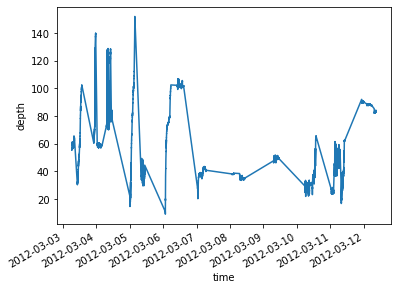

In [43]:
%%time
zarrs.depth.plot()

CPU times: user 55.4 ms, sys: 12.3 ms, total: 67.6 ms
Wall time: 61.5 ms


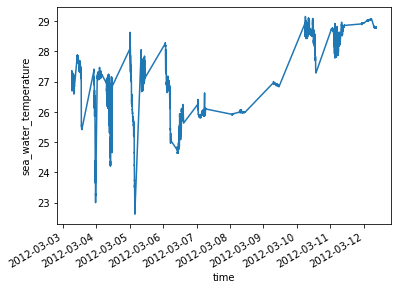

In [8]:
%%time
zarrs.sea_water_temperature.plot()

CPU times: user 63.1 ms, sys: 4.32 ms, total: 67.4 ms
Wall time: 61.6 ms


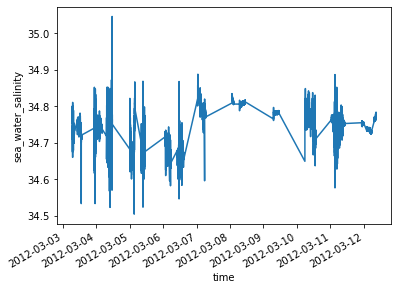

In [9]:
%%time
zarrs.sea_water_salinity.plot()

In [10]:
# check size of stored zarr
!du -h '/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr'

152K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/dive_report_path
152K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/ geospatial_vertical_max
604K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/depth
152K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/number_of_images
152K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/ geospatial_lon_min
204K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/cluster_tag
152K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/pattern
288K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/low_right_lat
256K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/up_right_lon
832K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/altitude_sensor
284K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/latitude
288K	/home/ec2-user/SageMaker/nc2zarr/notebooks/csv/output/za.zarr/low_left_lat
152K	/home/ec2-user/SageMa